# Levarage PubChem IDs for predicting of promoters of the Rab9 receptor; MORGAN2 features.

### Content   <a name="content"></a>

1. [Upload and analyse PubChem BioAssay AID 485297 on Rab9 receptor ](#1)
2. [Create a data frame with CIDs, SIDs and targets](#2)
3. [Upload and analyse PubChem BioAssay AID 1996 on water solubility ](#3)
4. [Create the final data frame, crossing the data frame that holds the targets with the water solubility data frame](#4)
5. [Ensure an equal number of classes in the test sets](#5)
6. [Scaling](#6)
7. [Balancing](#7)
8. [Machine Learning](#8)
9. [Cross validation](#9)
10. [Scrutinise for overfitting](#10)
11. [Hyperparameter tuning](#11)
12. [Final ML model](#12)
13. [Plot the learning curve ans AUC](#13)
14. [Confusion matrix](#14)
15. [Matthews Correlation Coefficient](#15)
16. [Classification report](#16)
17. [LIME analyse](#17)

## Upload and analyse PubChem BioAssay AID 485297 on Rab9 receptor <a name="1"></a>

In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit import RDLogger 
from typing import List, Optional
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Configuration
FP_RADIUS = 2    # Morgan Fingerprint radius. (Radius 2 = MORGAN2 = ECFP4)
FP_BITS = 1024   # The length of the output binary vector.

# Global Fix: Disable RDKit console warnings
# This line prevents "SMILES Parse Error" messages from cluttering the console.
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL) # Set level to CRITICAL to suppress INFO, WARNING, and ERROR messages

import rdkit
print(rdkit.__version__)

2023.09.5


In [2]:
import pandas as pd 

# load the BioAssay PubChem AID 485287 dataset
df_targets = pd.read_csv('2.Rab9_PubChem_AID_485297.csv', sep=';', low_memory=False)

# To avoid truncation of some columns during data frame display
pd.set_option('display.max_columns', None) 

# Display the data frame
print('Shape of the data frame: ', df_targets.shape)
df_targets.head()

Shape of the data frame:  (321292, 29)


,PUBCHEM_RESULT_TAG,SID,CID,PUBCHEM_EXT_DATASOURCE_SMILES,target,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PUBCHEM_ASSAYDATA_COMMENT,Phenotype,Potency,Efficacy,Analysis Comment,Curve_Description,Fit_LogAC50,Fit_HillSlope,Fit_R2,Fit_InfiniteActivity,Fit_ZeroActivity,Fit_CurveClass,Excluded_Points,Max_Response,Activity at 0.00295 uM,Activity at 0.015 uM,Activity at 0.074 uM,Activity at 0.369 uM,Activity at 1.840 uM,Activity at 9.220 uM,Activity at 46.10 uM,Compound QC
0,6,26666195,900061,CC1=NC2=C(C(=O)N1N)SC(=C2)C3=CC=C(C=C3)OC,Active,99,NaN,NaN,Activator,0.0032,96,NaN,Complete curve,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7,22410431,9663711,CC1=NN(C(=C1/C=N/NC2=CC=CC(=C2)C(=O)O)Cl)C3=CC...,Active,98,NaN,NaN,Activator,0.1,136.832,NaN,Complete curve,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8,24815344,9689184,CC1=C(SC=C1)/C=N/NC2=CC=CC(=C2)C(=O)O,Active,98,NaN,NaN,Activator,0.0032,2.???,NaN,Complete curve,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9,56314694,8821035,CC(=O)NC1=CC=CC(=C1)C(=O)OCC(=O)C2=CC3=C(C=C2)...,Active,97,NaN,NaN,Activator,0.0891,121.613,NaN,Complete curve,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10,24780447,1878864,CCCCCN1C=CC(=C2C(=O)C3=CC=CC=C3C2=O)C=C1,Active,97,NaN,NaN,Activator,0.0158,101.5,NaN,Complete curve,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df_targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321292 entries, 0 to 321291
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   PUBCHEM_RESULT_TAG             321292 non-null  int64  
 1   SID                            321292 non-null  int64  
 2   CID                            321292 non-null  int64  
 3   PUBCHEM_EXT_DATASOURCE_SMILES  321292 non-null  object 
 4   target                         321292 non-null  object 
 5   PUBCHEM_ACTIVITY_SCORE         321292 non-null  int64  
 6   PUBCHEM_ACTIVITY_URL           0 non-null       float64
 7   PUBCHEM_ASSAYDATA_COMMENT      0 non-null       float64
 8   Phenotype                      321292 non-null  object 
 9   Potency                        21985 non-null   object 
 10  Efficacy                       21985 non-null   object 
 11  Analysis Comment               0 non-null       float64
 12  Curve_Description             

In [4]:
# Remove duplicates 
df_targets.drop_duplicates()
df_targets.shape  # 353737 means no duplicates

(321292, 29)

In [5]:
# Remove compounds with missing CID-s
df_targets = df_targets[df_targets['CID'].notna()]
df_targets.shape

(321292, 29)

In [6]:
# Remove compounds with missing SID-s
df_targets = df_targets[df_targets['SID'].notna()]
df_targets.shape

(321292, 29)

In [7]:
import numpy as np
# Turn CID float data type into integer
df_targets['CID'] = df_targets['CID'].astype(np.int64) 
df_targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321292 entries, 0 to 321291
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   PUBCHEM_RESULT_TAG             321292 non-null  int64  
 1   SID                            321292 non-null  int64  
 2   CID                            321292 non-null  int64  
 3   PUBCHEM_EXT_DATASOURCE_SMILES  321292 non-null  object 
 4   target                         321292 non-null  object 
 5   PUBCHEM_ACTIVITY_SCORE         321292 non-null  int64  
 6   PUBCHEM_ACTIVITY_URL           0 non-null       float64
 7   PUBCHEM_ASSAYDATA_COMMENT      0 non-null       float64
 8   Phenotype                      321292 non-null  object 
 9   Potency                        21985 non-null   object 
 10  Efficacy                       21985 non-null   object 
 11  Analysis Comment               0 non-null       float64
 12  Curve_Description             

In [8]:
# Analise the Active compounds
df_Active = df_targets[df_targets['target']=='Active']
df_Active.describe(include='all')

,PUBCHEM_RESULT_TAG,SID,CID,PUBCHEM_EXT_DATASOURCE_SMILES,target,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PUBCHEM_ASSAYDATA_COMMENT,Phenotype,Potency,Efficacy,Analysis Comment,Curve_Description,Fit_LogAC50,Fit_HillSlope,Fit_R2,Fit_InfiniteActivity,Fit_ZeroActivity,Fit_CurveClass,Excluded_Points,Max_Response,Activity at 0.00295 uM,Activity at 0.015 uM,Activity at 0.074 uM,Activity at 0.369 uM,Activity at 1.840 uM,Activity at 9.220 uM,Activity at 46.10 uM,Compound QC
count,9138.000000,9.138000e+03,9.138000e+03,9138,9138,9138.000000,0.0,0.0,9138,9138,9138,0.0,9138,0.0,0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0,0
unique,NaN,NaN,NaN,9128,1,NaN,NaN,NaN,1,64,8938,NaN,2,NaN,0,NaN,0,0,NaN,0,0,0,0,0,0,0,0,0,0
top,NaN,NaN,NaN,C1=CC=C(C(=C1)C2=NC(=NO2)C3=CC(=CC=C3)C(=O)N)F,Active,NaN,NaN,NaN,Activator,3.1623,115.486,NaN,Partial curve,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,2,9138,NaN,NaN,NaN,9138,980,3,NaN,7581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,4574.500000,2.584991e+07,7.815767e+06,NaN,NaN,52.820858,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,2638.057714,1.688115e+07,2.081487e+07,NaN,NaN,15.728530,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,6.000000,8.421400e+05,2.048000e+03,NaN,NaN,40.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,2290.250000,1.473641e+07,8.727908e+05,NaN,NaN,45.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,4574.500000,2.479390e+07,2.543156e+06,NaN,NaN,46.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,6858.750000,4.719846e+07,5.790850e+06,NaN,NaN,49.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Amalise the Inactive compound
df_Inactive = df_targets[df_targets['target']=='Inactive']
df_Inactive.describe(include='all')

,PUBCHEM_RESULT_TAG,SID,CID,PUBCHEM_EXT_DATASOURCE_SMILES,target,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PUBCHEM_ASSAYDATA_COMMENT,Phenotype,Potency,Efficacy,Analysis Comment,Curve_Description,Fit_LogAC50,Fit_HillSlope,Fit_R2,Fit_InfiniteActivity,Fit_ZeroActivity,Fit_CurveClass,Excluded_Points,Max_Response,Activity at 0.00295 uM,Activity at 0.015 uM,Activity at 0.074 uM,Activity at 0.369 uM,Activity at 1.840 uM,Activity at 9.220 uM,Activity at 46.10 uM,Compound QC
count,301951.000000,3.019510e+05,3.019510e+05,301951,301951,301951.0,0.0,0.0,301951,2646,2646,0.0,2646,1362.000000,1362,1362.000000,1362,1362,300667.000000,271382,300667,800,1206,296056,298755,297662,298728,1110,300667
unique,NaN,NaN,NaN,301297,1,NaN,NaN,NaN,2,65,2601,NaN,3,NaN,49,NaN,1319,764,NaN,20,122742,705,887,100630,99798,101701,122172,990,86
top,NaN,NaN,NaN,CC(=O)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3[C@H]2CCC4...,Inactive,NaN,NaN,NaN,Inactive,???.96,96,NaN,Single point of activity,NaN,???.49,NaN,-100,0,NaN,0 0 0 0,???.71,???.17,???.01,???.33,???.47,???.91,???.71,???.25,QC'd by DPISMR
freq,NaN,NaN,NaN,4,301951,NaN,NaN,NaN,299305,377,7,NaN,1362,NaN,707,NaN,42,62,NaN,190681,682,6,8,695,681,688,679,7,54174
mean,170320.553156,2.804521e+07,1.049935e+07,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.367216,NaN,0.977088,NaN,NaN,3.968291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,87166.466679,1.890946e+07,2.304922e+07,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.325912,NaN,0.045254,NaN,NaN,0.470066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,19345.000000,8.421210e+05,6.000000e+00,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.350000,NaN,0.340800,NaN,NaN,-3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,94832.500000,1.473770e+07,1.599461e+06,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.500000,NaN,0.975225,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,170320.000000,2.480132e+07,3.239030e+06,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.300000,NaN,0.992650,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,245808.500000,4.967140e+07,9.549697e+06,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.200000,NaN,0.998700,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


[<a href="#content">Back to top</a>]

## Create a data frame with CIDs, SIDs and targets <a name="2"></a>

In [10]:
# Create a data frame containing the classification targets
df_targets = df_targets [['CID', 'SID', 'PUBCHEM_EXT_DATASOURCE_SMILES', 'target']]

# Display the data frame
print('Shape of df_targets : ', df_targets .shape)
df_targets .head()

Shape of df_targets :  (321292, 4)


,CID,SID,PUBCHEM_EXT_DATASOURCE_SMILES,target
0,900061,26666195,CC1=NC2=C(C(=O)N1N)SC(=C2)C3=CC=C(C=C3)OC,Active
1,9663711,22410431,CC1=NN(C(=C1/C=N/NC2=CC=CC(=C2)C(=O)O)Cl)C3=CC...,Active
2,9689184,24815344,CC1=C(SC=C1)/C=N/NC2=CC=CC(=C2)C(=O)O,Active
3,8821035,56314694,CC(=O)NC1=CC=CC(=C1)C(=O)OCC(=O)C2=CC3=C(C=C2)...,Active
4,1878864,24780447,CCCCCN1C=CC(=C2C(=O)C3=CC=CC=C3C2=O)C=C1,Active


In [11]:
# Check the classes in the bioassay
df_targets['target'].value_counts()

target
Inactive        301951
Inconclusive     10201
Active            9138
Unspecified          2
Name: count, dtype: int64

In [12]:
# Remove the Inconclusive samples 
df_targets = df_targets[df_targets['target']!='Inconclusive']
df_targets = df_targets[df_targets['target']!='Unspecified']
df_targets['target'].value_counts()

target
Inactive    301951
Active        9138
Name: count, dtype: int64

In [13]:
# Set the binary targets to "1" for an active antagonist and "0" for inactive 
df_targets = df_targets.copy()

# Create a dictionary
targets = {'Active' : 1,
           'Inactive' : 0}

# Replace the names with binary values set up in the dictionary targets
df_targets.target = [targets[item] for item in df_targets.target]

# Check how many unique values there are in the 'target' column
print('Unique values: ', df_targets['target'].unique())

# Count each of the binary targets
df_targets['target'].value_counts()

Unique values:  [1 0]


target
0    301951
1      9138
Name: count, dtype: int64

In [14]:
# Display the data frame
print('Shape of the df_targets: ', df_targets.shape)
df_targets.head()

Shape of the df_targets:  (311089, 4)


,CID,SID,PUBCHEM_EXT_DATASOURCE_SMILES,target
0,900061,26666195,CC1=NC2=C(C(=O)N1N)SC(=C2)C3=CC=C(C=C3)OC,1
1,9663711,22410431,CC1=NN(C(=C1/C=N/NC2=CC=CC(=C2)C(=O)O)Cl)C3=CC...,1
2,9689184,24815344,CC1=C(SC=C1)/C=N/NC2=CC=CC(=C2)C(=O)O,1
3,8821035,56314694,CC(=O)NC1=CC=CC(=C1)C(=O)OCC(=O)C2=CC3=C(C=C2)...,1
4,1878864,24780447,CCCCCN1C=CC(=C2C(=O)C3=CC=CC=C3C2=O)C=C1,1


In [15]:
# Creat a dataframe with full set of target 1 for latter use
df_targets_1 = df_targets[df_targets['target']==1]

[<a href="#content">Back to top</a>]

## Upload and analyse PubChem BioAssay AID 1996 on water solubility <a name="3"></a>

In [16]:
# Load data from PubChem BioAssay AID 1996 
df_solubility = pd.read_csv('0.Solubility_pubChem_AID_1996.csv')

# Display the data frame
print('Shape of df_solubility: ', df_solubility.shape)
df_solubility.head()

Shape of df_solubility:  (57859, 30)


,PUBCHEM_RESULT_TAG,SID,CID,PUBCHEM_EXT_DATASOURCE_SMILES,OUTCOME,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PUBCHEM_ASSAYDATA_COMMENT,Solubility at pH 7.4_Qualifier_Mean,Solubility at pH 7.4_Mean,Test Concentration_1,Solubility at pH 7.4_Qualifier_1,Solubility at pH 7.4_1,Solubility at pH 7.4_Comment_1,Solubility of Astemizole at pH 7.4_Qualifier_1,Solubility of Astemizole at pH 7.4_1,Solubility of Sulfamethizole at pH 7.4_Qualifier_1,Solubility of Sulfamethizole at pH 7.4_1,Solubility of Imipramine HCl at pH 7.4_Qualifier_1,Solubility of Imipramine HCl at pH 7.4_1,Test Concentration_2,Solubility at pH 7.4_Qualifier_2,Solubility at pH 7.4_2,Solubility at pH 7.4_Comment_2,Solubility of Astemizole at pH 7.4_Qualifier_2,Solubility of Astemizole at pH 7.4_2,Solubility of Sulfamethizole at pH 7.4_Qualifier_2,Solubility of Sulfamethizole at pH 7.4_2,Solubility of Imipramine HCl at pH 7.4_Qualifier_2,Solubility of Imipramine HCl at pH 7.4_2
0,1,24826444,2374148,COC1=CC=C(C=C1)OCC2=NNC(=S)N2N,Active,40,NaN,NaN,=,10.85,200,<,0.1,Below LOQ,=,14.2,>,40.5,>,47.5,200.0,=,21.6,NaN,=,27.7,>,40.5,>,47.5
1,2,49669186,5295761,CC1=CC(=C(C=C1)NC2=NC3=CC=CC=C3N4C2=NN=C4)Cl,Inactive,0,NaN,NaN,<,0.10,200,<,0.1,Below LOQ,=,12.3,>,40.5,>,47.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,49669768,22431387,CC1=CC(=CC=C1)CCNC2=NC3=C(C=C(C=C3)C)N4C2=NN=C4,Inactive,0,NaN,NaN,<,0.10,200,<,0.1,Below LOQ,=,12.3,>,40.5,>,47.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,8139962,14296,CC1=C(N=C(C(=N1)C)C)C,Inactive,0,NaN,NaN,<,0.10,200,<,0.1,Below LOQ,=,11.4,>,40.5,>,47.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,24803435,865684,CC1=CC2=NC(=C(C=C2C=C1)C#N)NC3=CC=CC=C3OC,Inactive,0,NaN,NaN,<,0.20,200,<,0.2,Below LOQ,=,11.4,>,40.5,>,47.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
df_solubility.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57859 entries, 0 to 57858
Data columns (total 30 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   PUBCHEM_RESULT_TAG                                  57859 non-null  int64  
 1   SID                                                 57859 non-null  int64  
 2   CID                                                 57859 non-null  int64  
 3   PUBCHEM_EXT_DATASOURCE_SMILES                       57859 non-null  object 
 4   OUTCOME                                             57859 non-null  object 
 5   PUBCHEM_ACTIVITY_SCORE                              57859 non-null  int64  
 6   PUBCHEM_ACTIVITY_URL                                0 non-null      float64
 7   PUBCHEM_ASSAYDATA_COMMENT                           0 non-null      float64
 8   Solubility at pH 7.4_Qualifier_Mean                 57859 non-null  object 


In [18]:
# Create the desired data frame with CID and SID for sifting 
df_solubility = df_solubility[['SID', 'CID']]

# Display the data frame
print('Shape of the data frame: ', df_solubility.shape)
df_solubility.head()

Shape of the data frame:  (57859, 2)


,SID,CID
0,24826444,2374148
1,49669186,5295761
2,49669768,22431387
3,8139962,14296
4,24803435,865684


[<a href="#content">Back to top</a>]

## Create the final data frame, crossing the data frame that holds the targets with the water solubility data frame  <a name="4"></a>

In [19]:
# Sift the main data frame with targets using the solubility data frame 
df = pd.merge(df_targets, df_solubility, on=["CID", "SID"])

# Display the data frame
print('Shape of the data frame: ', df.shape)
df.head()

Shape of the data frame:  (47918, 4)


,CID,SID,PUBCHEM_EXT_DATASOURCE_SMILES,target
0,900061,26666195,CC1=NC2=C(C(=O)N1N)SC(=C2)C3=CC=C(C=C3)OC,1
1,9689184,24815344,CC1=C(SC=C1)/C=N/NC2=CC=CC(=C2)C(=O)O,1
2,2853283,47201700,CC1=CC=C(C=C1)C(=O)NC2=NC=C(S2)[N+](=O)[O-],1
3,737745,49641371,CC(C)C(=O)NC1=CC2=NN(N=C2C=C1)C3=CC=C(C=C3)F,1
4,723105,47202833,CC1=CC=C(C=C1)C(=O)NCCC2=CC=CC=C2,1


In [20]:
# Count values of the sifted data frame 
df['target'].value_counts()

target
0    45402
1     2516
Name: count, dtype: int64

In [21]:
# Create a data frame with target 0
df_0 = df[df['target']==0]

# Concatenate the sifted target 0 with the original target 1
df = pd.concat([df_0, df_targets_1])

# Display the data frame
print('Shape of the data frame: ', df.shape)
df.head()

Shape of the data frame:  (54540, 4)


,CID,SID,PUBCHEM_EXT_DATASOURCE_SMILES,target
2516,1581462,24802453,C1=CC=NC(=C1)NC(=O)CCCOC2=C(C=C(C=C2)Cl)Cl,0
2517,9585902,49667877,C1CN(CCN1C(=O)C2=CC=CC=N2)/C(=N/[N+](=O)[O-])/N,0
2518,930177,26666716,CC(=O)NC(=S)NC1=CC=C(C=C1)NC(=O)C2=CN=CC=C2,0
2519,9585823,47204613,CC1=C(N2C=CC=CC2=N1)C(=O)N/N=C/C3=CC=C(C=C3)F,0
2520,5923263,26666715,CC1(C(SC(=S)N1C)/[N+](=C/C2=CC=CC=C2OC)/[O-])C,0


In [22]:
df.to_csv("HF_human_M1_muscarinic_receptor_antagonists_CID_SID.csv", index=False)
# Display the data frame
print('Shape of the data frame: ', df.shape)
df.head()

Shape of the data frame:  (54540, 4)


,CID,SID,PUBCHEM_EXT_DATASOURCE_SMILES,target
2516,1581462,24802453,C1=CC=NC(=C1)NC(=O)CCCOC2=C(C=C(C=C2)Cl)Cl,0
2517,9585902,49667877,C1CN(CCN1C(=O)C2=CC=CC=N2)/C(=N/[N+](=O)[O-])/N,0
2518,930177,26666716,CC(=O)NC(=S)NC1=CC=C(C=C1)NC(=O)C2=CN=CC=C2,0
2519,9585823,47204613,CC1=C(N2C=CC=CC2=N1)C(=O)N/N=C/C3=CC=C(C=C3)F,0
2520,5923263,26666715,CC1(C(SC(=S)N1C)/[N+](=C/C2=CC=CC=C2OC)/[O-])C,0


In [23]:
# Count the target
df['target'].value_counts()

target
0    45402
1     9138
Name: count, dtype: int64

In [24]:
# Shuffle the resulting data set
df = df.sample(
    frac = 1,        # Return entire dataframe
    random_state=1   # Make result reproducible
    ).reset_index(drop=True)

In [25]:
# Handle the part of target 1 in the test set 
df_1 = df[df['target']==1]

# Shuffle the resulting data set
df_1 = df_1.sample(
    frac = 1,        # Return entire dataframe
    random_state=1   # Make result reproducible
    ).reset_index(drop=True)

In [26]:
# Handle the part of target 0 in the test set 
df_0 = df[df['target']==0]

# Shuffle the resulting data set
df_0 = df_0.sample(
    frac = 1,        # Return entire dataframe
    random_state=1   # Make result reproducible
    ).reset_index(drop=True)

# Extract every nth row (e.g., every 4th row)
n = 4
df_0 = df_0[df_0.index % n == 0] 

# Shuffle the resulting data set
df_0 = df_0.sample(
    frac = 1,        # Return entire dataframe
    random_state=1   # Make result reproducible
    ).reset_index(drop=True)

In [27]:
# Create train and test dataframe for further manipulation 
df = pd.concat([df_0, df_1])

[<a href="#content">Back to top</a>]

## Create the MORGAN2 RDkit features <a name="2"></a>

In [28]:
import time

# Record the start time
start_time = time.time()

In [29]:
# Create a variable smiles
smiles = df['PUBCHEM_EXT_DATASOURCE_SMILES']

def smiles_to_morgan2_array(smiles: str, radius: int = FP_RADIUS, n_bits: int = FP_BITS) -> Optional[np.ndarray]:
    """
    Generates a single Morgan fingerprint (as a NumPy array) from a SMILES string.
    Returns None if the SMILES is invalid.
    """
    try:
        # Note: Chem.MolFromSmiles will return None for invalid SMILES, 
        # but the logging is now suppressed by the global setting above.
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
            
        # 1. Generate the Morgan Fingerprint BitVect
        # Morgan (radius=2) is the RDKit implementation of ECFP4.
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=n_bits)
        
        # 2. Convert the BitVect to a 1D NumPy array
        fp_array = np.array(fp, dtype=np.int8)
        return fp_array
    except Exception as e:
        # Catch any other Python errors and print them if they occur
        print(f"Internal processing error for SMILES '{smiles}': {e}")
        return None
def process_dataframe_to_features(df: pd.DataFrame, smiles_column: str) -> Optional[np.ndarray]:
    """
    Applies the Morgan fingerprint generation across the DataFrame.
    """
    print(f"Starting feature generation for {len(df)} molecules...")
    
    # Apply the function to the SMILES column
    fingerprint_series = df[smiles_column].apply(smiles_to_morgan2_array)
    
    # Filter out rows where fingerprint generation failed (invalid SMILES)
    valid_fingerprints = fingerprint_series.dropna().tolist()
    
    invalid_count = len(df) - len(valid_fingerprints)
    if invalid_count > 0:
        print(f"Warning: Dropped {invalid_count} row(s) due to invalid SMILES.")
    
    if not valid_fingerprints:
        print("Error: No valid fingerprints generated.")
        return None
    
    # Stack all 1D arrays into a single 2D NumPy feature matrix (X)
    X_features = np.vstack(valid_fingerprints)
    
    return X_features
# Generate MORGAN2 Features 
X_morgan2 = process_dataframe_to_features(df, smiles_column='PUBCHEM_EXT_DATASOURCE_SMILES')

# Prepare Targets (y) 
# We must ensure that the target vector (y) only contains labels for the *valid* molecules.
valid_mask = df['PUBCHEM_EXT_DATASOURCE_SMILES'].apply(lambda x: Chem.MolFromSmiles(x) is not None)
y_targets = df[valid_mask]['target'].values

# Final Output
if X_morgan2 is not None:
    print("\n--- Final Output Ready for ML ---")
    print(f"X_features (MORGAN2) shape: {X_morgan2.shape}")
    print(f"y_targets shape: {y_targets.shape}")
    print("\nFirst 3 rows of the MORGAN2 feature matrix (X) (first 15 bits):")
    print(X_morgan2[:3, :15])

Starting feature generation for 20489 molecules...

--- Final Output Ready for ML ---
X_features (MORGAN2) shape: (20489, 1024)
y_targets shape: (20489,)

First 3 rows of the MORGAN2 feature matrix (X) (first 15 bits):
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]]


[<a href="#content">Back to top</a>]

## Data preperation for Machine learning <a name="3"></a>

In [30]:
# Split Data for Training and Testing
X_train, X_test, y_train, y_test = train_test_split(
    X_morgan2, 
    y_targets, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_targets
)

print("\n--- ML Data Split Summary ---")
print(f"Training Samples: {len(X_train)}")
print(f"Testing Samples: {len(X_test)}")
print("Data is now ready for model training")


--- ML Data Split Summary ---
Training Samples: 16391
Testing Samples: 4098
Data is now ready for model training


In [31]:
# # Keeping sets for the cross validation  
X_cv = X_train
y_cv = y_train

In [32]:
from sklearn.preprocessing import StandardScaler

# Standardise the data points
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [33]:
# Print the shape of each part
print("Shapes:")
print("X_train: ", X_train.shape)
print("X_test:  ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test:  ", y_test.shape)

Shapes:
X_train:  (16391, 1024)
X_test:   (4098, 1024)
y_train:  (16391,)
y_test:   (4098,)


[<a href="#content">Back to top</a>]

## Balancing <a name="7"></a>

[(0, 9081), (1, 7310)]


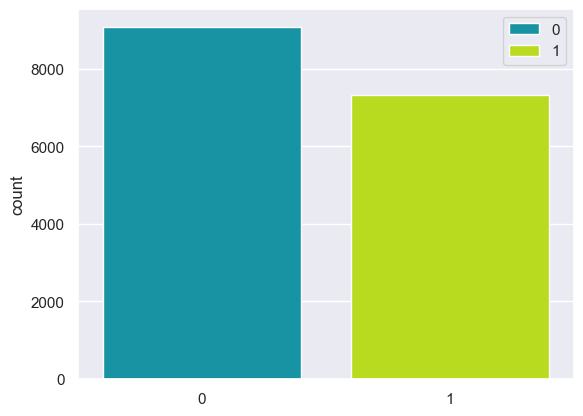

In [34]:
from collections import Counter
from matplotlib import pyplot as plt
import seaborn as sns

# Plot the imbalance between the targets 
print(sorted(Counter(y_train).items()))
sns.set_style('white')
sns.set(font_scale=1)
plt.figure()
sns.countplot(x=y_train, hue=y_train, palette='nipy_spectral')
plt.show()

[(0, 9081), (1, 9081)]


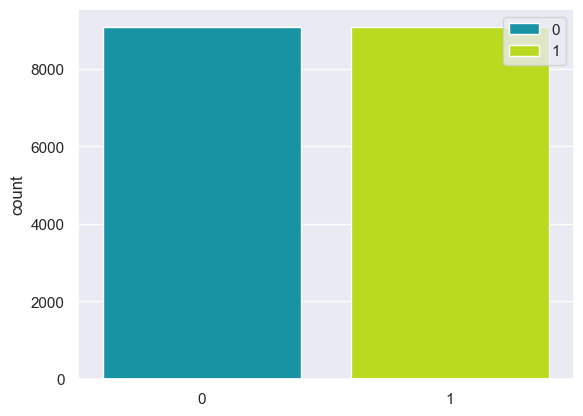

In [35]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()

X_train, y_train = ros.fit_resample(X_train, y_train)

# Plot the balance between classification targets 
print(sorted(Counter(y_train).items()))
sns.set_style('white')
sns.set(font_scale=1)
plt.figure()
sns.countplot(x=y_train, hue=y_train,palette='nipy_spectral')
plt.show()

In [36]:
# Print the shape of each part
print("Shapes:")
print("X_train: ", X_train.shape)
print("X_test:  ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test:  ", y_test.shape)

Shapes:
X_train:  (18162, 1024)
X_test:   (4098, 1024)
y_train:  (18162,)
y_test:   (4098,)


[<a href="#content">Back to top</a>]

## Machine Learning <a name="8"></a>

In [37]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt

# Instantiate the estimator 
model = GradientBoostingClassifier(random_state=42)

# Train  
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
acc = round(accuracy_score(y_test, y_pred),3)
print('Accuracy: ', acc)
pre = round(precision_score(y_test, y_pred),3)
print('Precision: ', pre) 
rec = round(recall_score(y_test, y_pred),3)
print('Recall: ',rec) 
f1 = round(f1_score(y_test, y_pred),3)
print('F1: ', f1) 
roc = round(roc_auc_score(y_test, y_pred),3) 
print('ROC: ', roc)

Accuracy:  0.78
Precision:  0.74
Recall:  0.781
F1:  0.76
ROC:  0.78


In [38]:
# Record the end time
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time
print(f"Time elapsed: {elapsed_time:.4f} seconds")

Time elapsed: 140.4327 seconds


[<a href="#content">Back to top</a>]

## Cross-validation  <a name="9"></a>

In [39]:
# Five-fold cross-validation
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix 

# Define the Model
model = GradientBoostingClassifier(random_state=42)

# Number of folds
n_splits = 5

# Stratified K-Fold ensures balanced class distribution in each fold
# This ensures that each training and test fold has a similar percentage of class 1.
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Lists to store metrics from each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

# --- 3. Cross-Validation Loop with Manual SMOTE Resampling ---
print(f"Performing {n_splits}-Fold Stratified Cross-Validation with Manual SMOTE...\n")

# Initialize the SMOTE object once
# smote= SMOTE(random_state=42)

for fold, (train_index, test_index) in enumerate(skf.split(X_cv, y_cv)):
    print(f"--- Fold {fold + 1}/{n_splits} ---")

    # Split data for the current fold
    X_train_cv, X_test_cv = X_cv[train_index], X_cv[test_index]
    y_train_cv, y_test_cv = y_cv[train_index], y_cv[test_index]

    # Report class distributions before resampling
    print(f"  Training set class distribution (Original): {np.bincount(y_train_cv)}")
    print(f"  Test set class distribution: {np.bincount(y_test_cv)}")

    # Apply SMOTE oversampling on the training split only
    # This is the step that replaces the imblearn pipeline logic.
    X_train_resampled, y_train_resampled = ros.fit_resample(X_train_cv, y_train_cv)
    print(f"  Training set (after SMOTE) class distribution: {np.bincount(y_train_resampled)}")

    # Train the model on the resampled training data
    model.fit(X_train_resampled, y_train_resampled)

    # Make predictions on the *original, untouched* test data
    y_pred_cv = model.predict(X_test_cv)
    # Get probabilities for ROC AUC calculation
    y_prob_cv = model.predict_proba(X_test_cv)[:, 1]

    # Evaluate performance for the current fold
    accuracy = accuracy_score(y_test_cv, y_pred_cv)
    precision = precision_score(y_test_cv, y_pred_cv, zero_division=0)
    recall = recall_score(y_test_cv, y_pred_cv, zero_division=0)
    f1 = f1_score(y_test_cv, y_pred_cv, zero_division=0)
    roc_auc = roc_auc_score(y_test_cv, y_prob_cv)

    # Store scores
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    roc_auc_scores.append(roc_auc)

    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall (Sensitivity): {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  ROC AUC: {roc_auc:.4f}")
    print(f"  Confusion Matrix:\n{confusion_matrix(y_test_cv, y_pred_cv)}\n")
    print("-" * 30)


# --- 4. Aggregate and Report Final Metrics ---
print("\n--- Cross-Validation Results Summary ---")

# Convert lists to NumPy arrays for easier statistical manipulation
accuracy_scores = np.array(accuracy_scores)
precision_scores = np.array(precision_scores)
recall_scores = np.array(recall_scores)
f1_scores = np.array(f1_scores)
roc_auc_scores = np.array(roc_auc_scores)

print(f"Average Accuracy: {np.mean(accuracy_scores):.4f} +/- {np.std(accuracy_scores):.4f}")
print(f"Average Precision: {np.mean(precision_scores):.4f} +/- {np.std(precision_scores):.4f}")
print(f"Average Recall: {np.mean(recall_scores):.4f} +/- {np.std(recall_scores):.4f}")
print(f"Average F1-Score: {np.mean(f1_scores):.4f} +/- {np.std(f1_scores):.4f}")
print(f"Average ROC AUC: {np.mean(roc_auc_scores):.4f} +/- {np.std(roc_auc_scores):.4f}")
print("\n--- Summary ---")
print("The standard deviation (+/-) indicates the stability of the model performance across the different folds.")

Performing 5-Fold Stratified Cross-Validation with Manual SMOTE...

--- Fold 1/5 ---
  Training set class distribution (Original): [7264 5848]
  Test set class distribution: [1817 1462]
  Training set (after SMOTE) class distribution: [7264 7264]
  Accuracy: 0.7755
  Precision: 0.7351
  Recall (Sensitivity): 0.7763
  F1-Score: 0.7552
  ROC AUC: 0.8553
  Confusion Matrix:
[[1408  409]
 [ 327 1135]]

------------------------------
--- Fold 2/5 ---
  Training set class distribution (Original): [7265 5848]
  Test set class distribution: [1816 1462]
  Training set (after SMOTE) class distribution: [7265 7265]
  Accuracy: 0.7752
  Precision: 0.7386
  Recall (Sensitivity): 0.7674
  F1-Score: 0.7528
  ROC AUC: 0.8575
  Confusion Matrix:
[[1419  397]
 [ 340 1122]]

------------------------------
--- Fold 3/5 ---
  Training set class distribution (Original): [7265 5848]
  Test set class distribution: [1816 1462]
  Training set (after SMOTE) class distribution: [7265 7265]
  Accuracy: 0.7706
  Pr

[<a href="#content">Back to top</a>]

## Scrutinise for overfitting  <a name="11"></a>

In [40]:
# Evaluate XGBClassifier performance on train and test sets with different tree depths
train_scores, test_scores = list(), list()
# define the tree depths to evaluate
values = [i for i in range(1, 21)]
# evaluate a decision tree for each depth
for i in values:
 # configure the model
 model_ = GradientBoostingClassifier(max_depth=i)
 # fit model_ on the training dataset
 model_.fit(X_train, y_train)
 # evaluate on the train dataset
 train_yhat = model_.predict(X_train)
 train_acc = accuracy_score(y_train, train_yhat)
 train_scores.append(train_acc)
 # evaluate on the test dataset
 test_yhat = model_.predict(X_test)
 test_acc = accuracy_score(y_test, test_yhat)
 test_scores.append(test_acc)
 # summarize progress
 print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))

>1, train: 0.715, test: 0.706
>2, train: 0.764, test: 0.753
>3, train: 0.794, test: 0.780
>4, train: 0.832, test: 0.799
>5, train: 0.865, test: 0.816
>6, train: 0.897, test: 0.831
>7, train: 0.925, test: 0.841
>8, train: 0.952, test: 0.851
>9, train: 0.973, test: 0.857
>10, train: 0.987, test: 0.862
>11, train: 0.995, test: 0.857
>12, train: 0.998, test: 0.861
>13, train: 0.999, test: 0.868
>14, train: 1.000, test: 0.869
>15, train: 1.000, test: 0.867
>16, train: 1.000, test: 0.875
>17, train: 1.000, test: 0.869
>18, train: 1.000, test: 0.865
>19, train: 1.000, test: 0.866
>20, train: 1.000, test: 0.865


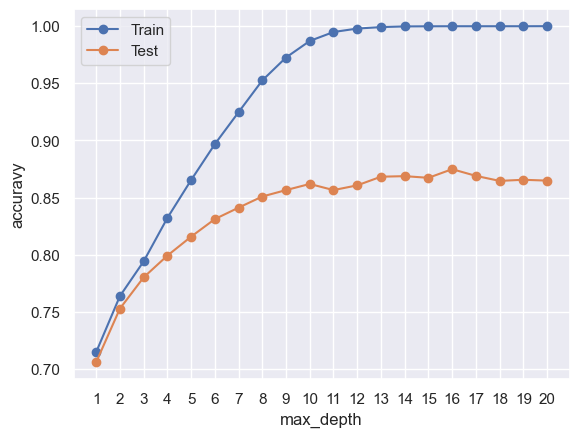

In [41]:
import math

# Set integers for x axis
new_x_ticks = range(math.floor(min(values)), math.ceil(max(values))+1)
plt.xticks(new_x_ticks)
# Plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.legend()
plt.xlabel("max_depth")
plt.ylabel("accuravy")
plt.show()

In [44]:
# ML with the suggested hyperparameters 
model = GradientBoostingClassifier(max_depth=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
acc = round(accuracy_score(y_test, y_pred),3)
print('Accuracy: ', acc)
pre = round(precision_score(y_test, y_pred),3)
print('Precision: ', pre) 
rec = round(recall_score(y_test, y_pred),3)
print('Recall: ',rec) 
f1 = round(f1_score(y_test, y_pred),3)
print('F1: ', f1) 
roc = round(roc_auc_score(y_test, y_pred),3) 
print('ROC: ', roc)

Accuracy:  0.816
Precision:  0.779
Recall:  0.819
F1:  0.799
ROC:  0.816


[<a href="#content">Back to top</a>]

## Hyperparameter tuning  <a name="11"></a>

In [45]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],        # Number of boosting stages (trees)
    'learning_rate': [0.01, 0.1, 0.2],      # Contribution of each tree
    'max_depth': [5],                 # Maximum depth of the individual regression estimators
    'min_samples_leaf': [1, 5, 10],         # Minimum number of samples required to be at a leaf node
    'subsample': [0.8, 1.0]                 # Fraction of samples used for fitting the individual trees
}

# Create the model
model = GradientBoostingClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                          cv=5, scoring='accuracy', verbose=2) 
grid_search.fit(X_train, y_train) 

# Print the best parameters and score
print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END learning_rate=0.01, max_depth=5, min_samples_leaf=1, n_estimators=100, subsample=0.8; total time= 1.3min
[CV] END learning_rate=0.01, max_depth=5, min_samples_leaf=1, n_estimators=100, subsample=0.8; total time= 1.3min
[CV] END learning_rate=0.01, max_depth=5, min_samples_leaf=1, n_estimators=100, subsample=0.8; total time= 1.3min
[CV] END learning_rate=0.01, max_depth=5, min_samples_leaf=1, n_estimators=100, subsample=0.8; total time= 1.3min
[CV] END learning_rate=0.01, max_depth=5, min_samples_leaf=1, n_estimators=100, subsample=0.8; total time= 1.3min
[CV] END learning_rate=0.01, max_depth=5, min_samples_leaf=1, n_estimators=100, subsample=1.0; total time= 1.7min
[CV] END learning_rate=0.01, max_depth=5, min_samples_leaf=1, n_estimators=100, subsample=1.0; total time= 1.7min
[CV] END learning_rate=0.01, max_depth=5, min_samples_leaf=1, n_estimators=100, subsample=1.0; total time= 1.7min
[CV] END learning_rate=0.0

In [46]:
# Evaluate random forest classifier performance on train and test sets with different tree depths
train_scores, test_scores = list(), list()
# define the tree depths to evaluate
values = [i for i in range(1, 21)]
# evaluate a decision tree for each depth
for i in values:
 # configure the model
 model_ = GradientBoostingClassifier(max_depth=i,
                        learning_rate=0.2,
                        min_samples_leaf=1,
                        n_estimators=300,
                        subsample=0.8)
 # fit model_ on the training dataset
 model_.fit(X_train, y_train)
 # evaluate on the train dataset
 train_yhat = model_.predict(X_train)
 train_acc = accuracy_score(y_train, train_yhat)
 train_scores.append(train_acc)
 # evaluate on the test dataset
 test_yhat = model_.predict(X_test)
 test_acc = accuracy_score(y_test, test_yhat)
 test_scores.append(test_acc)
 # summarize progress
 print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))

>1, train: 0.781, test: 0.773
>2, train: 0.839, test: 0.805
>3, train: 0.892, test: 0.827
>4, train: 0.938, test: 0.835
>5, train: 0.977, test: 0.858
>6, train: 0.995, test: 0.856
>7, train: 0.999, test: 0.867
>8, train: 1.000, test: 0.866
>9, train: 1.000, test: 0.872
>10, train: 1.000, test: 0.876
>11, train: 1.000, test: 0.878
>12, train: 1.000, test: 0.874
>13, train: 1.000, test: 0.881
>14, train: 1.000, test: 0.880
>15, train: 1.000, test: 0.876
>16, train: 1.000, test: 0.880
>17, train: 1.000, test: 0.879
>18, train: 1.000, test: 0.879
>19, train: 1.000, test: 0.881
>20, train: 1.000, test: 0.880


In [ ]:
# Set integers for x axis
new_x_ticks = range(math.floor(min(values)), math.ceil(max(values))+1)
plt.xticks(new_x_ticks)
# Plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.legend()
plt.xlabel("max_depth")
plt.ylabel("accuravy")
plt.show()

In [47]:
# ML with the suggested hyperparameters 
model = GradientBoostingClassifier(max_depth=2,
                        learning_rate=0.2,
                        min_samples_leaf=1,
                        n_estimators=300,
                        subsample=0.8)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
acc = round(accuracy_score(y_test, y_pred),3)
print('Accuracy: ', acc)
pre = round(precision_score(y_test, y_pred),3)
print('Precision: ', pre) 
rec = round(recall_score(y_test, y_pred),3)
print('Recall: ',rec) 
f1 = round(f1_score(y_test, y_pred),3)
print('F1: ', f1) 
roc = round(roc_auc_score(y_test, y_pred),3) 
print('ROC: ', roc)

Accuracy:  0.808
Precision:  0.77
Recall:  0.812
F1:  0.791
ROC:  0.809


In [48]:
from sklearn.model_selection import cross_val_score
import optuna

def objective(trial):
    """
    Objective function for Optuna hyperparameter optimization.

    Args:
        trial: An Optuna trial object.

    Returns:
        The negative accuracy score (to be minimized).
    """
    params = {
        'max_depth': 2,
        'n_estimators': trial.suggest_int('n_estimators', 50, 500, step=50),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
    }

    model = GradientBoostingClassifier(**params)
    accuracy = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
    return -accuracy  # Optuna minimizes the objective function

# Create a study object
study = optuna.create_study(direction='minimize') 

# Run the optimization
study.optimize(objective, n_trials=10)  # Adjust n_trials as needed

# Get the best hyperparameters
best_params = study.best_params

# Train the model with the best hyperparameters
best_model =  GradientBoostingClassifier(**best_params)
best_model.fit(X_train, y_train)

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred) 
print(f"Best Accuracy: {accuracy}")
print(f"Best Hyperparameters: {best_params}")

[I 2025-11-27 22:13:04,988] A new study created in memory with name: no-name-7bc8e8bf-aa6f-4025-bf82-68f381f5229b
[I 2025-11-27 22:18:22,391] Trial 0 finished with value: -0.7749700797025796 and parameters: {'n_estimators': 200, 'learning_rate': 0.09256958719366204, 'min_samples_split': 19, 'min_samples_leaf': 10, 'subsample': 0.7092634984711104}. Best is trial 0 with value: -0.7749700797025796.
[I 2025-11-27 22:34:41,790] Trial 1 finished with value: -0.7598833684373905 and parameters: {'n_estimators': 450, 'learning_rate': 0.025876002738627273, 'min_samples_split': 11, 'min_samples_leaf': 7, 'subsample': 0.9672773642216218}. Best is trial 0 with value: -0.7749700797025796.
[I 2025-11-27 22:39:56,722] Trial 2 finished with value: -0.802059801792429 and parameters: {'n_estimators': 250, 'learning_rate': 0.16856823398333792, 'min_samples_split': 7, 'min_samples_leaf': 4, 'subsample': 0.5520531403761262}. Best is trial 2 with value: -0.802059801792429.
[I 2025-11-27 22:40:53,170] Trial 3

Best Accuracy: 0.8347974621766715
Best Hyperparameters: {'n_estimators': 450, 'learning_rate': 0.23565427310049136, 'min_samples_split': 18, 'min_samples_leaf': 7, 'subsample': 0.6413927978077083}


[<a href="#content">Back to top</a>]

## Final ML model  <a name="12"></a>

In [49]:
model = GradientBoostingClassifier(max_depth=2,
                        learning_rate=0.23565427310049136,
                        min_samples_leaf=7,
                        min_samples_split=18,
                        n_estimators=450,
                        subsample=0.6413927978077083)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
acc = round(accuracy_score(y_test, y_pred),3)
print('Accuracy: ', acc)
pre = round(precision_score(y_test, y_pred),3)
print('Precision: ', pre) 
rec = round(recall_score(y_test, y_pred),3)
print('Recall: ',rec) 
f1 = round(f1_score(y_test, y_pred),3)
print('F1: ', f1) 
roc = round(roc_auc_score(y_test, y_pred),3) 
print('ROC: ', roc)

Accuracy:  0.82
Precision:  0.783
Recall:  0.824
F1:  0.803
ROC:  0.82


[<a href="#content">Back to top</a>]

## Plot the learning curve and AUC <a name="13"></a>

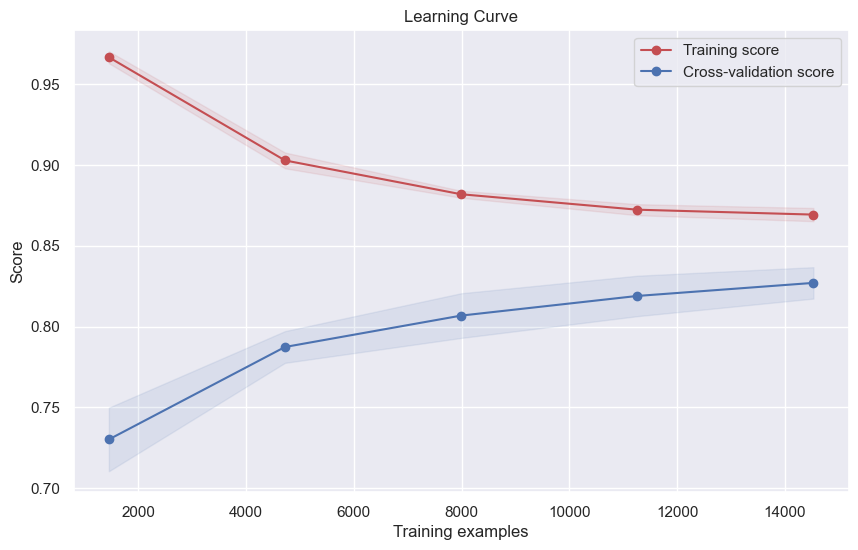

In [50]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")

plt.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r",
)
plt.fill_between(
    train_sizes,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.1,
    color="b",
)
plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, "o-", color="b", label="Cross-validation score")
plt.legend(loc="best")
plt.show()

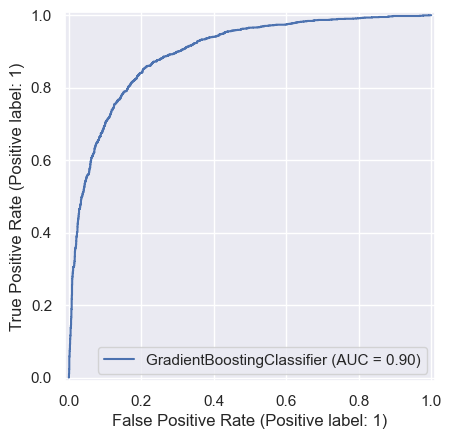

In [51]:
from sklearn.metrics import RocCurveDisplay

svc_disp = RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.show()

[<a href="#content">Back to top</a>]

## Confusion matrix<a name="14"></a>

[1507, 1852, 418, 321]

--- Classification Metrics ---
True Positives (TP): 1507
True Negatives (TN): 1852
False Positives (FP): 418
False Negatives (FN): 321
----------------------------



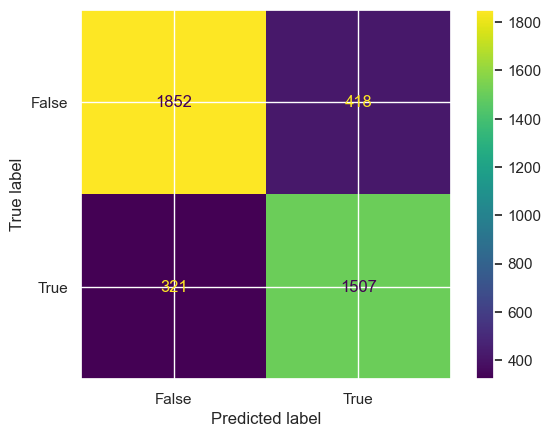

In [52]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

# # Calculate the confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

# Extract TP, TN, FP, FN 
# Use .ravel() to flatten the 2x2 matrix into a 1x4 array: [TN, FP, FN, TP]
TN, FP, FN, TP = confusion_matrix.ravel()
conf_matrix_list = [TP, TN, FP, FN]

# Print the list with metrics
print(conf_matrix_list)

# Print the metrics
print("\n--- Classification Metrics ---")
print(f"True Positives (TP): {TP}")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print("----------------------------\n")

# Display confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

[<a href="#content">Back to top</a>]

## Matthews Correlation Coefficient <a name="15"></a>

In [53]:
import math

def matthews_corr_coeff(TP: int, TN: int, FP: int, FN: int) -> float:
    """
    Calculates the Matthews Correlation Coefficient (MCC).

    MCC is a metric used to evaluate the quality of binary classifications.
    It takes into account true positives, true negatives, false positives, 
    and false negatives, making it a reliable measure even for imbalanced classes.

    The formula is:
    MCC = (TP * TN - FP * FN) / sqrt((TP + FP)(TP + FN)(TN + FP)(TN + FN))

    Args:
        TP (int): True Positives (correctly predicted positive cases).
        TN (int): True Negatives (correctly predicted negative cases).
        FP (int): False Positives (incorrectly predicted positive cases).
        FN (int): False Negatives (incorrectly predicted negative cases).

    Returns:
        float: The Matthews Correlation Coefficient, ranging from -1 (worst) 
               to +1 (best). Returns 0.0 if the denominator is zero.
    """
    
    # Calculate the numerator: (TP * TN) - (FP * FN)
    numerator = (TP * TN) - (FP * FN)
    
    # Calculate the components of the denominator
    # Note: These components are the marginal sums (sums of rows/columns in the confusion matrix)
    term_1 = TP + FP
    term_2 = TP + FN
    term_3 = TN + FP
    term_4 = TN + FN
    
    # Calculate the denominator: sqrt((TP + FP)(TP + FN)(TN + FP)(TN + FN))
    denominator = math.sqrt(term_1 * term_2 * term_3 * term_4)
    
    # Handle the case where the denominator is zero (which means one of the marginal
    # sums is zero, indicating an ill-defined problem or a trivial prediction). 
    # In this case, MCC is conventionally set to 0.
    if denominator == 0:
        print("Warning: Denominator is zero. Returning MCC = 0.0")
        return 0.0
    
    # Calculate the final MCC value
    mcc = numerator / denominator
    return mcc

# tp1, tn1, fp1, fn1 = [9090, 6115, 1966, 3201]
tp1, tn1, fp1, fn1 = conf_matrix_list
mcc1 = matthews_corr_coeff(tp1, tn1, fp1, fn1)
print(f"---  Model ---")
print(f"TP={tp1}, TN={tn1}, FP={fp1}, FN={fn1}")
print(f"MCC: {mcc1:.4f}\n")

---  Model ---
TP=1507, TN=1852, FP=418, FN=321
MCC: 0.6377



[<a href="#content">Back to top</a>]

## Classification report <a name="16"></a>

In [54]:
# Classification report 
from sklearn.metrics import classification_report

# Print the classification report 
target_names = ['Active (target 1) ', 'Inactive (target 0)']
print(classification_report(y_test, y_pred, target_names=target_names))

                     precision    recall  f1-score   support

 Active (target 1)        0.85      0.82      0.83      2270
Inactive (target 0)       0.78      0.82      0.80      1828

           accuracy                           0.82      4098
          macro avg       0.82      0.82      0.82      4098
       weighted avg       0.82      0.82      0.82      4098



[<a href="#content">Back to top</a>]

## Scrutinizing for robustness of the model <a name="19"></a>

In [55]:
model = GradientBoostingClassifier(max_depth=2,
                        learning_rate=0.2,
                        min_samples_leaf=1,
                        n_estimators=300,
                        subsample=0.8)
model.fit(X_train, y_train)

# Calculate baseline accuracy on the clean, un-noised/un-imputed test set (NumPy version)
baseline_accuracy = accuracy_score(y_test, model.predict(X_test))

print(f"Baseline Accuracy on clean test data: {baseline_accuracy:.4f}\n")
all_accuracy_scores = [] # List to store all individual noisy/imputed accuracies


Baseline Accuracy on clean test data: 0.8092



In [56]:
# Gausian nose robustness test
def add_gaussian_noise(data, noise_level=0.1):
    """Adds Gaussian noise to a dataset (NumPy array assumed)."""
    noise = np.random.normal(0, noise_level, data.shape)
    return data + noise

noise_levels_to_test = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

print("--- Running Gaussian Noise Robustness Test ---")
for noise_level in noise_levels_to_test:
    # Add Gaussian noise to the test set (using NumPy array)
    X_test_noisy = add_gaussian_noise(X_test, noise_level=noise_level)

    # Make predictions and calculate accuracy
    y_pred_noisy = model.predict(X_test_noisy)
    noisy_accuracy = accuracy_score(y_test, y_pred_noisy)

    all_accuracy_scores.append(noisy_accuracy)

    print(f"Level {noise_level:.1f}: Accuracy={noisy_accuracy:.4f}, Loss={baseline_accuracy - noisy_accuracy:.4f}")

--- Running Gaussian Noise Robustness Test ---
Level 0.1: Accuracy=0.8092, Loss=0.0000
Level 0.2: Accuracy=0.8092, Loss=0.0000
Level 0.3: Accuracy=0.8092, Loss=0.0000
Level 0.4: Accuracy=0.8084, Loss=0.0007
Level 0.5: Accuracy=0.8070, Loss=0.0022
Level 0.6: Accuracy=0.8043, Loss=0.0049


In [57]:
from sklearn.impute import SimpleImputer

# Missing values robustness test
def introduce_missing_values(data, missing_rate=0.1):
    """Introduces a specified rate of missing values (np.nan) into a dataset."""
    if isinstance(data, pd.DataFrame):
        data = data.values

    data_missing = data.copy().astype(float)
    num_missing = int(np.ceil(data.size * missing_rate))
    indices = np.random.choice(data.size, num_missing, replace=False)
    data_missing.flat[indices] = np.nan
    return data_missing

missing_rates = [0.1, 0.2, 0.3, 0.4]

print("\n--- Running Missing Value Robustness Test (Imputation) ---")

# We must fit the imputer on the training data (X_train_np) only once!
imputer = SimpleImputer(strategy='most_frequent')
imputer.fit(X_train)

for rate in missing_rates:
    # Introduce missing values in the test set (using NumPy array)
    X_test_missing = introduce_missing_values(X_test, missing_rate=rate)

    # Transform (impute) the missing data
    X_test_imputed = imputer.transform(X_test_missing)

    # Make predictions and calculate accuracy
    y_pred_imputed = model.predict(X_test_imputed)
    imputed_accuracy = accuracy_score(y_test, y_pred_imputed)

    all_accuracy_scores.append(imputed_accuracy)

    robustness_loss = baseline_accuracy - imputed_accuracy
    print(f"Rate {rate:.1f}: Accuracy={imputed_accuracy:.4f}, Loss={robustness_loss:.4f}")


--- Running Missing Value Robustness Test (Imputation) ---
Rate 0.1: Accuracy=0.7938, Loss=0.0154
Rate 0.2: Accuracy=0.7755, Loss=0.0337
Rate 0.3: Accuracy=0.7421, Loss=0.0671
Rate 0.4: Accuracy=0.7082, Loss=0.1010


In [58]:
# Overall average robustness calculation
num_tests = len(all_accuracy_scores)
overall_average_robustness = np.mean(all_accuracy_scores)

print(f"Total Robustness Tests Conducted: {num_tests}")
print(f"Overall Average Robustness (Accuracy): {overall_average_robustness:.4f}")
print("This metric represents the average accuracy the model maintained across all defined degradation scenarios.")

Total Robustness Tests Conducted: 10
Overall Average Robustness (Accuracy): 0.7867
This metric represents the average accuracy the model maintained across all defined degradation scenarios.


[<a href="#content">Back to top</a>]